## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)

In [3]:
display(data.index.is_monotonic)
display(data.head())
display(data.tail())
display(data.describe())
display(data.info())
display("Колличество пропусков:", data.isnull().sum(axis = 0))

True

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

'Колличество пропусков:'

num_orders    0
dtype: int64

По предварительному анализу данных, видно, что это монотонный временной ряд с шагом в 10 мин. Ресемплируем датасет на 1 час.

<AxesSubplot:xlabel='datetime'>

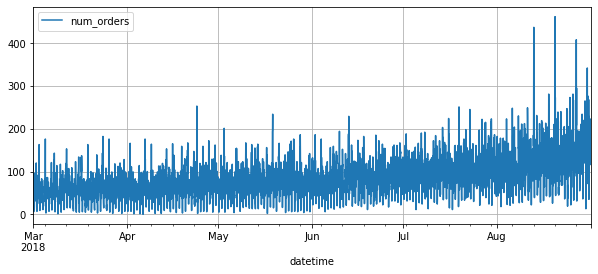

In [4]:
data = data.resample('1H').sum()
data.plot(figsize=(10, 4), grid=True)

По данному графику видно, что примерно с середины исследуемого периода, есть небольшой рост количества заказов такси.

## Анализ

Для прогнозирования количества заказов такси на следующий час, выделим из данных информацию о последнем месяце.

<AxesSubplot:xlabel='datetime'>

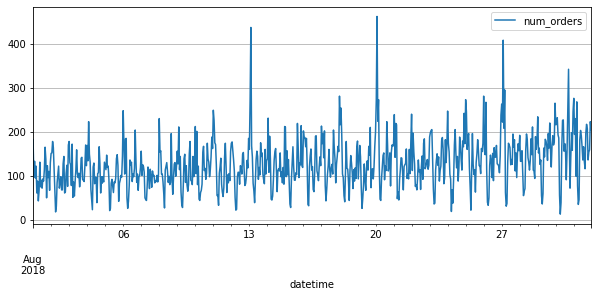

In [5]:
data = data['2018-08':]
data.plot(figsize=(10, 4), grid=True)

Из графика видно, что есть некоторые закономерности - увеличение количества заказов в выходные дни. Далее проанализируем их тренды и сезонность.

/tmp/ipykernel_239/1301055494.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rolling_mean'] = data.rolling(20).mean()


<AxesSubplot:xlabel='datetime'>

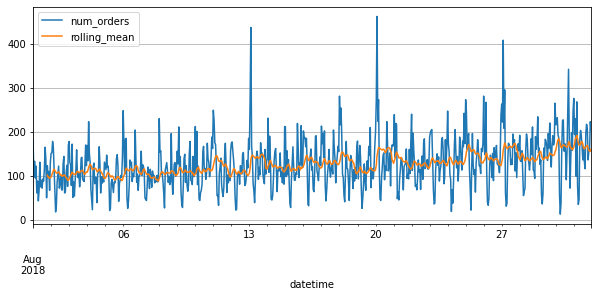

In [6]:
data['rolling_mean'] = data.rolling(20).mean()
data.plot(figsize=(10, 4), grid=True)

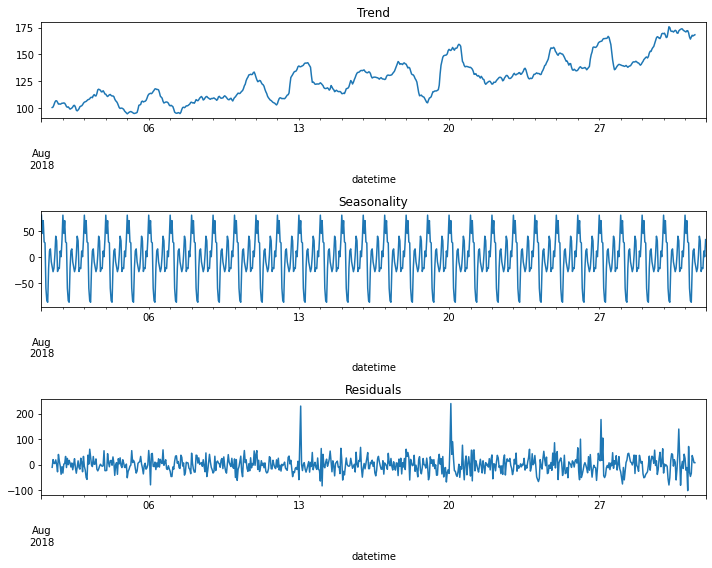

In [7]:
decomposed = seasonal_decompose(data['num_orders'])
plt.figure(figsize=(10, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Сезонность - один день, это объясняется типичным жизнью людей, утром по делам, вечером заказов практически нет. Тренд идет по нарастающей вверх.
Но ряд ещё не стационарный, поэтому вычислим разности временного ряда.

<AxesSubplot:xlabel='datetime'>

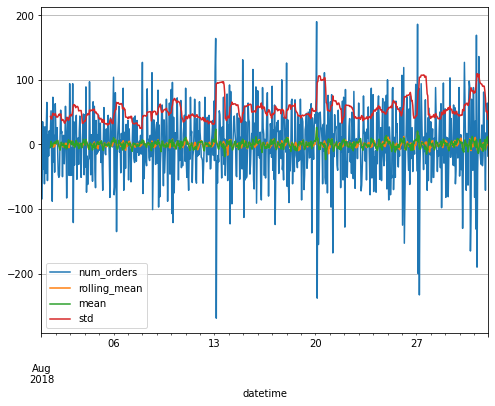

In [8]:
data = data - data.shift()
data['mean'] = data['num_orders'].rolling(15).mean()
data['std'] = data['num_orders'].rolling(15).std()
data.plot(figsize=(8, 6), grid=True)

Тренд нулевой. Ряд стал более стационарным, это значит, что данные можно прогнозировать.

## Обучение

In [9]:
# удалим столбцы ненужные для машинного обучения

data = data.drop(['rolling_mean','mean','std'], axis=1)

In [10]:
# проверим на пропуски

data.isnull().sum(axis = 0)

num_orders    1
dtype: int64

In [11]:
data = data.dropna()
data.isna().sum()

num_orders    0
dtype: int64

In [12]:
def make_features(df, max_lag, rolling_mean_size):
    """Функция создает дополнительные признака: календарные, «Отстающие значения» и 
    скользящего среднего
    
    """
    df = data.copy()
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df

df = make_features(data, 50, 50)

In [13]:
df.head()

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,lag_49,lag_50,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-01 01:00:00,-84.0,2018,8,1,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-08-01 02:00:00,35.0,2018,8,1,2,-84.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-08-01 03:00:00,-38.0,2018,8,1,2,35.0,-84.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-08-01 04:00:00,27.0,2018,8,1,2,-38.0,35.0,-84.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-08-01 05:00:00,-61.0,2018,8,1,2,27.0,-38.0,35.0,-84.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Создали 50 новых признаков для обучение. Далее раздели данные на обучающую и тестовую выборки (10%).

In [14]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
 
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [15]:
print(train.index.min(), train.index.max(), train.shape)
print(test.index.min(), test.index.max(), test.shape)

2018-08-03 03:00:00 2018-08-28 20:00:00 (618, 56)
2018-08-28 21:00:00 2018-08-31 23:00:00 (75, 56)


Данные разбиты верно - обучающая заканчивается 28 числа в 20.00, а тестовая начинается в 21.00 того же числа.

Проверим качество временных рядов без обучения двумя способами:
1. все значения тестовой выборки предсказываются константой;
2. заполнив новое значение прогнозируется предыдущим значением ряда. 

In [16]:
print("Среднее количество заказов такси в день:", test['num_orders'].mean())

pred_median = np.ones(target_test.shape) * target_train.median()

print("RMSE прогнозирования средним:", mean_squared_error(target_test, pred_median)**0.5)

Среднее количество заказов такси в день: 1.48
RMSE прогнозирования средним: 66.31480478244156


In [17]:
pred_previous = target_test.shift(fill_value=target_train.iloc[target_train.shape[0]-1])

print("RMSE прогнозируется предыдущим значением ряда:", mean_squared_error(target_test, pred_previous)**0.5)

RMSE прогнозируется предыдущим значением ряда: 101.10713789507314


## Тестирование

Спрогнозируем данные с помощью трех моделей: линейной регрессии, случайного леса и градиентного бустинга с с LightGBM.

### Линейная регрессия

In [18]:
model_LR = LinearRegression()
 
model_LR.fit(features_train, target_train)
pred_test_LR = model_LR.predict(features_test)
 
print("RMSE модели линейной регрессии:", mean_squared_error(target_test, pred_test_LR)**0.5)


RMSE модели линейной регрессии: 46.349011206753374


### Случайный лес

In [19]:
model_RF = RandomForestRegressor()

param_RF = {'max_depth' : [1, 6, 1], 'n_estimators' : [1, 5, 1]}

tscv = TimeSeriesSplit(n_splits=3)

model_GS = GridSearchCV(estimator=model_RF, cv=tscv,
                        param_grid=param_RF, scoring="neg_mean_absolute_error")

model_GS.fit(features_train, target_train)

pred_test_RF = model_GS.predict(features_test)
 
print("RMSE модели случайный лес:", mean_squared_error(target_test, pred_test_RF)**0.5)

RMSE модели случайный лес: 57.872233247442935


### Градиентный бустинг с LightGBM

In [20]:
model_LGBM = LGBMRegressor(learning_rate=0.1, 
                      num_leaves=200, 
                      random_state=12345)
model_LGBM.fit(features_train, target_train)

predictions_LGBM = model_LGBM.predict(features_test)

RMSE_LGBM = mean_squared_error(target_test, predictions_LGBM)**0.5

print("RMSE LightGBM:", RMSE_LGBM)

RMSE LightGBM: 55.31000986682489


/tmp/ipykernel_239/1111088273.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predictions_LGBM'] = predictions_LGBM


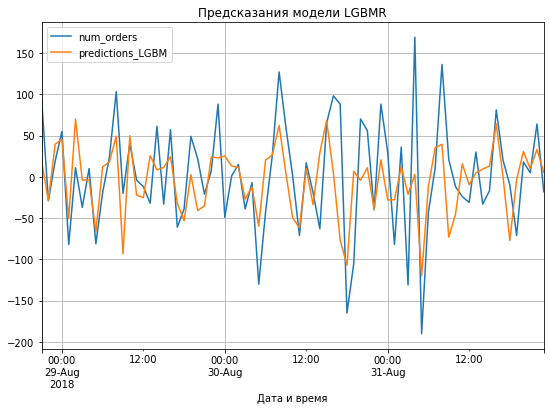

In [21]:
test['predictions_LGBM'] = predictions_LGBM

ax = test[['num_orders','predictions_LGBM']].plot(figsize=(9, 6), grid=True)

ax.set_title('Предсказания модели LGBMR')
ax.set_xlabel("Дата и время");

## Вывод

При проверке качества данных без машинного обучение  при помощи константы, результат равен RMSE 66.3. Но линейная модель показала, еще более лучший результат, RMSE равно 46.3, что соответствует поставленному условию нашего проекта. Поэтому, чтобы понимать, нужно ли, привлекать больше водителей в период пиковой нагрузки, нужно использовать модель Линейной регрессии, которая лучше всего определяет количество заказов такси на следующий час.